In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# TODO
from scipy.ndimage.measurements import label

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Helper functions listed here

In [2]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return img

In [18]:
class FeatureExtractor(object):
    def __init__(self, input_params):
        self.param_dict = input_params
        
        
    # Define a function to compute color histogram features
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 256)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def bin_spatial(self, img, size):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel()
        # Return the feature vector
        return features
    
    def get_hog_features(self, img, vis=False):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=self.param_dict['orient'],
                                      pixels_per_cell=(self.param_dict['pix_per_cell'], self.param_dict['pix_per_cell']),
                                      cells_per_block=(self.param_dict['cell_per_block'], self.param_dict['cell_per_block']),
#                                       transform_sqrt=True,
                                      transform_sqrt=False,
                                      visualise=True, feature_vector=True)
            return features, hog_image
        # Otherwise call with one output
        else:
            features = hog(img, orientations=self.param_dict['orient'],
                          pixels_per_cell=(self.param_dict['pix_per_cell'], self.param_dict['pix_per_cell']),
                          cells_per_block=(self.param_dict['cell_per_block'], self.param_dict['cell_per_block']),
                           transform_sqrt=False,
                           visualise=False, feature_vector=True)
            return features
    
    def extract_features(self, image):
        # Create a list to append feature vectors to
        features = []
        
        if np.max(image) > 1:
            image = image.astype(np.float32) / float(np.max(image))
            
        # apply color conversion if other than 'RGB'
        if self.param_dict['color_space'] != 'RGB':
            if self.param_dict['color_space'] == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif self.param_dict['color_space'] == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif self.param_dict['color_space'] == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif self.param_dict['color_space'] == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif self.param_dict['color_space'] == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)

        if self.param_dict['spatial_feat'] == True:
            spatial_features = self.bin_spatial(feature_image, size=self.param_dict['spatial_size'])
            features.append(spatial_features)
        if self.param_dict['hist_feat'] == True:
            # Apply color_hist()
            hist_features = self.color_hist(feature_image, nbins=self.param_dict['hist_bins'])
            features.append(hist_features)
        if self.param_dict['hog_feat'] == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if self.param_dict['hog_channel'] == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel]))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel])
            # Append the new feature vector to the features list
            features.append(hog_features)
        
        # Return list of feature vectors
        return np.concatenate(features)

In [16]:
class SearchandClassify(object):
    def __init__(self, input_params, svc, X_scaler):
        self.param_dict = input_params
        self.window_params = {
            'x_start_stop' : [760, 1260],
            'y_start_stop' : [320, 680],
            'xy_overlap' : (0.75, 0.8),
            'xy_window' : [64, 64],
            'window_sizes' : [60, 100, 150],
            'heat_threshold' : 2
        }
        self.svc = svc
        self.X_scaler = X_scaler
        self.heat_threshold = self.window_params['heat_threshold']
    
    # Define a function that takes an image,
    # start and stop positions in both x and y, 
    # window size (x and y dimensions),  
    # and overlap fraction (for both x and y)
    def slide_window(self, img, xy_window=(64, 64)):
        # If x and/or y start/stop positions not defined, set to image size
        if self.window_params['x_start_stop'][0] == None:
            self.window_params['x_start_stop'][0] = 0
        if self.window_params['x_start_stop'][1] == None:
            self.window_params['x_start_stop'][1] = img.shape[1]
        if self.window_params['y_start_stop'][0] == None:
            self.window_params['y_start_stop'][0] = 0
        if self.window_params['y_start_stop'][1] == None:
            self.window_params['y_start_stop'][1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = self.window_params['x_start_stop'][1] - self.window_params['x_start_stop'][0]
        yspan = self.window_params['y_start_stop'][1] - self.window_params['y_start_stop'][0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - self.window_params['xy_overlap'][0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - self.window_params['xy_overlap'][1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(self.window_params['xy_overlap'][0]))
        ny_buffer = np.int(xy_window[1]*(self.window_params['xy_overlap'][1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + self.window_params['x_start_stop'][0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + self.window_params['y_start_stop'][0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def search_windows(self, img, windows):
        #1) Create an empty list to receive positive detection windows
        on_windows = []
        #2) Iterate over all windows in the list
        for window in windows:
            #3) Extract the test window from original image
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
            #4) Extract features for that window using single_img_features()
#             features = self.single_img_features(test_img)
            features = FeatureExtractor(self.param_dict).extract_features(test_img)
            #5) Scale extracted features to be fed to classifier
            test_features = self.X_scaler.transform(np.array(features).reshape(1, -1))
            #6) Predict using your classifier
            prediction = self.svc.predict(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
        #8) Return windows for positive detections
        return on_windows
    
    def find_all_windows(self, img):
        window_list = []
        for xy in self.window_params['window_sizes']:
            window = self.slide_window(img, xy_window=(xy, xy))
            window_list += window
        return window_list
    
    def process_frame(self, image):
        image_copy1 = np.copy(image)
        image_copy2 = np.copy(image)
        
        if np.max(image) > 1:
            image = image.astype(np.float32) / float(np.max(image))

        windows = self.find_all_windows(image)
        hot_windows = self.search_windows(image, windows)

        heat = np.zeros_like(image_copy1[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heatmap = add_heat(heat, hot_windows)
           
        # Apply threshold to help remove false positives
        heat = apply_threshold(heatmap, self.heat_threshold)
        
        # Find final boxes from heatmap using label function
        labels = label(heat)
        result = draw_labeled_bboxes(image_copy2, labels)
        return result

In [5]:
# This is a bool which disables training classifier several times to save time
debug_run = 1

In [22]:
global my_params

my_params = {
        'color_space' : 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        'orient' : 9,    # HOG orientations
        'pix_per_cell' : 8,   # HOG pixels per cell
        'cell_per_block' : 2,  # HOG cells per block
        'hog_channel' : 'ALL', # Can be 0, 1, 2, or "ALL"
#         'spatial_size' : (32, 32),  # Spatial binning dimensions
        'spatial_size' : (16, 16),
        'hist_bins' : 16,   # Number of histogram bins
        'spatial_feat' : True, # Spatial features on or off
        'hist_feat' : True, # Histogram features on or off
        'hog_feat' : True, # HOG features on or off
    }

def train_classifier():
    # Divide up into cars and notcars
    cars = glob.glob('data/vehicles/*/*.png')
    notcars = glob.glob('data/non-vehicles/*/*.png')

    t=time.time()
    
    feature_extract = FeatureExtractor(my_params)

    car_features = []
    notcar_features = []

    for file in cars:
        image = mpimg.imread(file)
        car_feature = feature_extract.extract_features(image)
        car_features.append(car_feature)

    for file in notcars:
        image = mpimg.imread(file)
        notcar_feature = feature_extract.extract_features(image)
        notcar_features.append(notcar_feature)

    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)

    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:', my_params['orient'], 'orientations', my_params['pix_per_cell'],
        'pixels per cell and', my_params['cell_per_block'],'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc, X_scaler

# if debug_run == 1:
svc, X_scaler = train_classifier()
#     debug_run = 0

73.85 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
2.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  0.  0.  0.  0.]
0.0014 Seconds to predict 10 labels with SVC


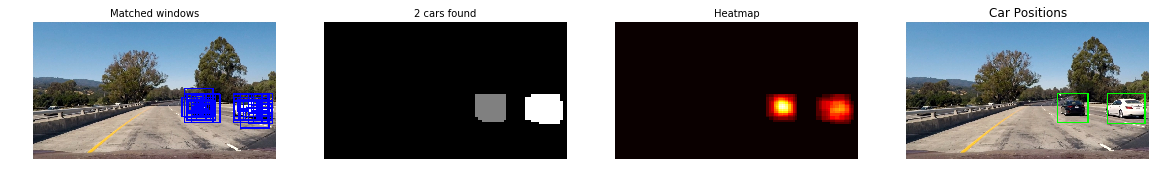

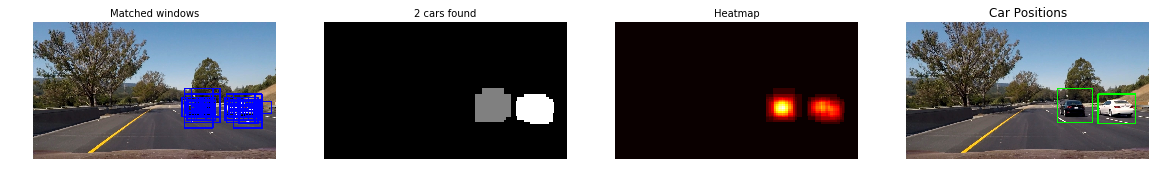

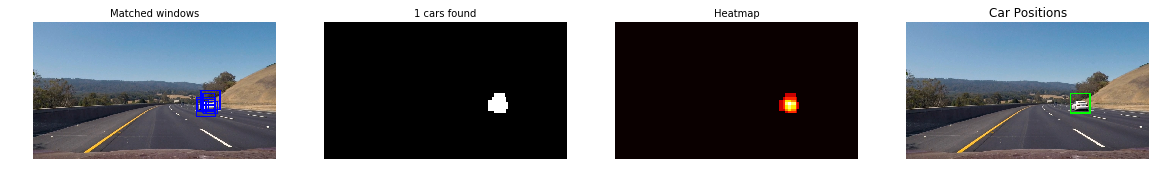

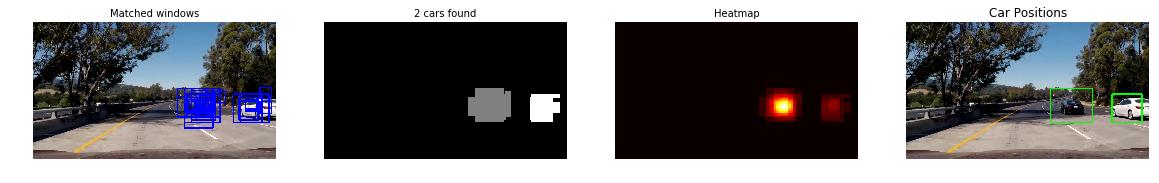

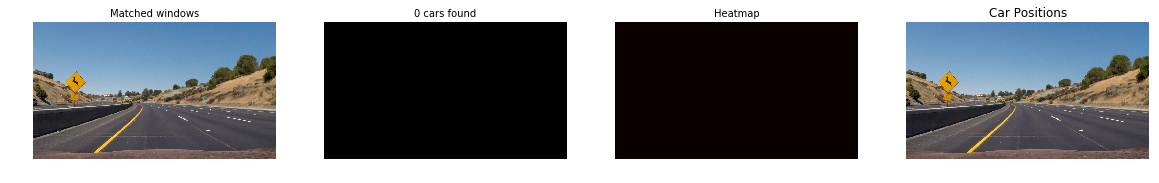

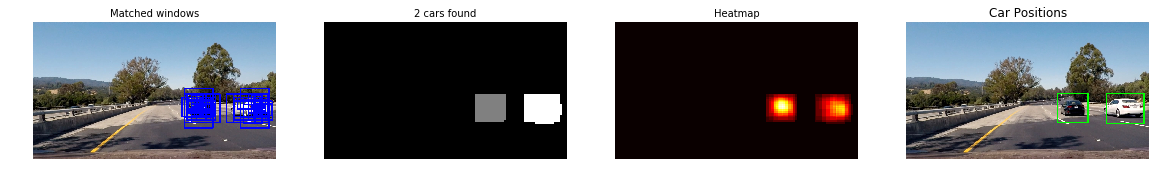

In [24]:
search_classify_obj = SearchandClassify(my_params, svc, X_scaler)

test_images = glob.glob('test_images/*.jpg')

def test_pipeline(each_file, debug=False):
    image = mpimg.imread(each_file)
    image_copy = np.copy(image)
    
    if np.max(image) > 1:
        image = image.astype(np.float32) / float(np.max(image))
    
    windows = search_classify_obj.find_all_windows(image)
    hot_windows = search_classify_obj.search_windows(image, windows)
    window_img = draw_boxes(image_copy, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)
    # Find final boxes from heatmap using label function
    labels = label(heat)
    result = draw_labeled_bboxes(image_copy, labels)
    
    if debug == True:
        f, (sp1, sp2, sp3, sp4) = plt.subplots(1, 4, figsize=(20,12))
        sp1.imshow(window_img)
        sp1.set_title('Matched windows', fontsize=10)
        sp1.axis('off')

        sp2.imshow(labels[0], cmap='gray')
        sp2.set_title('{} cars found'.format(labels[1]), fontsize=10)
        sp2.axis('off')

        sp3.imshow(heat, cmap='hot')
        sp3.set_title('Heatmap', fontsize=10)
        sp3.axis('off')

        sp4.imshow(result)
        sp4.set_title('Car Positions')
        sp4.axis('off')
    else:
        return result

class_use = False

for each_file in test_images:
    if class_use == False:
        test_pipeline(each_file, debug=True)
    else:
        image = mpimg.imread(each_file)
        result = search_classify_obj.process_frame(image)
        plt.imshow(result)
        plt.axis('off')
        plt.show()

In [8]:
video_output = 'output_images/test_video_output_clipped.mp4'
# video_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
# clip1 = clip_orig.subclip(2,6)
# clip1 = VideoFileClip('test_video.mp4')
clip1_output = clip1.fl_image(search_classify_obj.process_frame) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_output_clipped.mp4
[MoviePy] Writing video output_images/test_video_output_clipped.mp4


 99%|█████████▉| 100/101 [07:04<00:04,  4.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_output_clipped.mp4 

CPU times: user 7min 4s, sys: 324 ms, total: 7min 4s
Wall time: 7min 4s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))